In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import scipy.linalg
import scipy.signal
import nengo
import matplotlib.pyplot as plt
import tqdm

import sys
sys.path.append('../../lib')
from temporal_encoder_common import *

In [4]:
tauIn = [0.01, 0.02, 0.03]
tauRec = [0.1, 0.11, 0.12]

In [5]:
res = solve_for_linear_dynamics(
    [Filters.lowpass_chained(t) for t in tauIn] +
    [Filters.lowpass_chained(t1, t2) for t1 in tauRec for t2 in tauIn] +
    [Filters.lowpass_chained(t1, t2) for t1 in tauRec for t2 in tauRec],
    [Filters.dirac()] * 12 + [Filters.step()] * 9,
    [Filters.step()],
    T=10.0,
    N_smpls=1000,
    sigma=None,
)

100%|██████████| 1000/1000 [00:11<00:00, 86.48it/s]


In [6]:
M1 = res[0:3]
M2 = res[3:12].reshape(3, 3)
M3 = res[12:21].reshape(3, 3)
M1, M2, M3

(array([[0.00399877],
        [0.00719494],
        [0.00819198]]),
 array([[-0.12310559, -0.13980689, -0.1612393 ],
        [ 0.02693611,  0.02875555,  0.03107015],
        [ 0.16269033,  0.17789805,  0.19652494]]),
 array([[7.44777660e-11, 1.88978731e-01, 1.66666657e-01],
        [1.88978731e-01, 2.58628124e-10, 1.44354611e-01],
        [1.66666657e-01, 1.44354611e-01, 5.84173296e-11]]))

In [7]:
def LP(*args):
    return nengo.LinearFilter(*Filters.lowpass_laplace_chained(*args), analog=True)

T = 10.0
high = 5.0

with nengo.Network() as model:
    #u = nengo.Node(lambda t: 1.0 * (t >= 0.5) * (t < 1.5))
    u = nengo.Node(nengo.processes.WhiteSignal(period=T, high=high))

    y = nengo.Ensemble(n_neurons=1,
                       dimensions=1,
                       neuron_type=nengo.Direct())

    for i, tau in enumerate(tauIn):
        nengo.Connection(u, y, synapse=tau, transform=M1[i])
    for i, tau1 in enumerate(tauRec):
        for j, tau2 in enumerate(tauIn):
            nengo.Connection(u, y, synapse=LP(tau1, tau2), transform=M2[i, j])
    for i, tau1 in enumerate(tauRec):
        for j, tau2 in enumerate(tauRec):
            nengo.Connection(y, y, synapse=LP(tau1, tau2), transform=M3[i, j])

    p_u = nengo.Probe(u, synapse=None)
    p_y = nengo.Probe(y, synapse=None)

with nengo.Simulator(model) as sim:
    sim.run(T)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

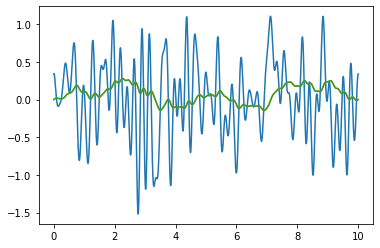

In [9]:
fig, ax = plt.subplots()
ax.plot(sim.trange(), sim.data[p_u])
ax.plot(sim.trange(), np.cumsum(sim.data[p_u]) * 1e-3)
ax.plot(sim.trange(), sim.data[p_y])